In [271]:
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import joblib
import os

In [272]:
SEED = 42424
np.random.seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)



In [273]:
# Load the data sets and combine them into a single usable dataframe called data series
data_series = pd.read_csv('./data/data_avg_temp.csv')

# rename columns to be more descriptive
data_series.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
data_series.drop(columns=['avg_temp_anomaly'], inplace=True)

# append to the dataframe
data_cool_degree = pd.read_csv('./data/data_cool_degree_days.csv')
data_heat_degree = pd.read_csv('./data/data_heat_degree_days.csv')
data_max_temp = pd.read_csv('./data/data_max_temp.csv')
data_min_temp = pd.read_csv('./data/data_min_temp.csv')
data_palmer_z = pd.read_csv('./data/data_palmer_z.csv')
data_pdsi = pd.read_csv('./data/data_pdsi.csv')
data_phdi = pd.read_csv('./data/data_phdi.csv')
data_pmdi = pd.read_csv('./data/data_pmdi.csv')
data_precipitation = pd.read_csv('./data/data_precipitation.csv')



# Append columns to the data series
# data_series['cool_degree_days'] = data_cool_degree['Value']
# data_series['cool_degree_days_anomaly'] = data_cool_degree['Anomaly']

# data_series['heat_degree_days'] = data_heat_degree['Value']
# data_series['heat_degree_days_anomaly'] = data_heat_degree['Anomaly']

data_series['max_temp'] = data_max_temp['Value']
# data_series['max_temp_anomaly'] = data_max_temp['Anomaly']

data_series['min_temp'] = data_min_temp['Value']
# data_series['min_temp_anomaly'] = data_min_temp['Anomaly']

data_series['palmer_z'] = data_palmer_z['Value']
# data_series['palmer_z_anomaly'] = data_palmer_z['Anomaly']

data_series['pdsi'] = data_pdsi['Value']
# data_series['pdsi_anomaly'] = data_pdsi['Anomaly']

data_series['phdi'] = data_phdi['Value']
# data_series['phdi_anomaly'] = data_phdi['Anomaly']

data_series['pmdi'] = data_pmdi['Value']
# data_series['pmdi_anomaly'] = data_pmdi['Anomaly']

data_series['precipitation'] = data_precipitation['Value']
# data_series['precipitation_anomaly'] = data_precipitation['Anomaly']




In [274]:
# Convert dataframe to numpy array
avg_temp = data_series['avg_temp'].to_numpy()
data_series.drop(columns=['avg_temp'], inplace=True)

# x = data_series.to_numpy()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data_series, avg_temp, test_size=0.2, random_state=SEED)


std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train[['max_temp', 'min_temp']])
x_test_scaled = std_scaler.transform(x_test[['max_temp', 'min_temp']])

# Append to x_train and x_test
robust_scaler = RobustScaler()
x_train_scaled = np.append(x_train_scaled, robust_scaler.fit_transform(x_train[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
x_test_scaled = np.append(x_test_scaled, robust_scaler.transform(x_test[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)

minmax_scaler = MinMaxScaler()
x_train_scaled = np.append(x_train_scaled, minmax_scaler.fit_transform(x_train[['precipitation']]), axis=1)
x_test_scaled = np.append(x_test_scaled, minmax_scaler.transform(x_test[['precipitation']]), axis=1)

joblib.dump(std_scaler, 'std_scaler.joblib')
joblib.dump(robust_scaler, 'robust_scaler.joblib')
joblib.dump(minmax_scaler, 'minmax_scaler.joblib')



# Normalize the data
# Define the ColumnTransformer with appropriate scalers
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('std', StandardScaler(), ['max_temp', 'min_temp']),
#         ('robust', RobustScaler(), ['cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi']),
#         ('minmax', MinMaxScaler(), ['precipitation'])
#     ]
# )

# Fit the ColumnTransformer to the data
# x_train_scaled = preprocessor.fit(x_train)
# x_test_scaled = preprocessor.transform(x_test)

# joblib.dump(preprocessor, 'preprocessor.joblib') 

# Convert the data for the GRU model to numpy
# x_train_scaled = x_train_scaled.to_numpy()
# x_test_scaled = x_test_scaled.to_numpy()

# Expand first dim
x_train_scaled = np.expand_dims(x_train_scaled, axis=0)
x_test_scaled = np.expand_dims(x_test_scaled, axis=0)
y_train = np.expand_dims(y_train, axis=0)
y_test = np.expand_dims(y_test, axis=0)

print(x_train_scaled.shape)


(1, 1229, 7)


In [ ]:
# Train the GRU model
model_gru = Sequential(
    [
        GRU(20, activation='relu', 
        input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])),
        Dense(1)
    ]
)

model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(x_train_scaled, y_train, epochs=3500 , batch_size=1,verbose=1, validation_data=(x_test_scaled, y_test))


Epoch 1/3500


/home/frederik/miniconda3/envs/ml_new_mexico/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step - loss: 2858.1848 - val_loss: 2840.2566
Epoch 2/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 2853.5745 - val_loss: 2838.1729
Epoch 3/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2849.0381 - val_loss: 2836.0889
Epoch 4/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2844.5522 - val_loss: 2834.0032
Epoch 5/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2840.1497 - val_loss: 2831.9136
Epoch 6/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2835.8042 - val_loss: 2829.8323
Epoch 7/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2831.4990 - val_loss: 2827.7737
Epoch 8/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2827.2288 - val_loss: 2825.7119
Epoch 9/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2823.0129 - val_loss: 2823.6777
Epoch 10/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2818.8354 - val_loss: 2821.6279
Epoch 11/3500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2814.6748 - val_loss: 2819.5562
Epoch 12/

In [276]:
# Predict the temperature by regressing the other features and then predicting average temperature
parameters = ['max_temp', 'min_temp', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']
models = {}
scalers = {}

date = data_series['date'].to_numpy()
date_splice = np.zeros((len(date), 2))

param_models = []

for i, element in enumerate(date):
    # print(element)
    # Splice this string to get year and month
    date_splice[i,0] = int(str(element)[0:4])
    date_splice[i,1] = int(str(element)[5:7])

for param in parameters:
    print(f"PARAM", param)
    y = data_series[param].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(date_splice, y, test_size=0.2, shuffle=False, random_state=SEED)

    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_train.shape[1],)),  # input_shape=(2,)
        Dense(1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=1)

    # Save model
    param_models.append(model)


PARAM max_temp
Epoch 1/500


/home/frederik/miniconda3/envs/ml_new_mexico/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3376369.0000 - val_loss: 3146961.7500
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2822914.5000 - val_loss: 2621065.7500
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2349301.2500 - val_loss: 2173424.5000
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1947443.1250 - val_loss: 1795453.1250
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1606327.8750 - val_loss: 1477081.0000
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1320987.1250 - val_loss: 1209343.5000
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1080506.6250 - val_loss: 984890.6875
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 878707.4375 - val_loss: 797176.6250
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 710644.6250 - val_loss: 641039.6875
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 569626.1875 - val_loss: 511724.4688
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

In [277]:
# Prediction of the average temperature
# Using the trained models to predict the parameters and then use those predictions as input for the GRU model

years = 60
date_predict = np.zeros((years*12, 2))
for i in range(years*12):
    date_predict[i, 0] = 2024 + i // 12
    date_predict[i, 1] = 1 + i % 12


param_predicts = np.zeros((len(parameters),years*12))

#  Predict the parameters.
for k, model in enumerate(param_models):
    for i in range(years*12):
        answer = model.predict(date_predict[i].reshape(1, -1))
        param_predicts[k, i] = answer

yearmonth_vec = np.zeros((years*12,1))
for i in range(years*12):
    yearmonth_vec[i] = date_predict[i, 0] * 100 + date_predict[i, 1]

# params_predicts = np.append(yearmonth_vec, param_predicts.T, axis=1)

columns = ['max_temp', 'min_temp', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']

df_predict = pd.DataFrame(param_predicts.T, columns=columns)

# Normalize the data with the same scalers
predict_scaled = std_scaler.transform(df_predict[['max_temp', 'min_temp']])
predict_scaled = np.append(predict_scaled, robust_scaler.transform(df_predict[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
predict_scaled = np.append(predict_scaled, minmax_scaler.transform(df_predict[['precipitation']]), axis=1)

# predict_scaled = np.append(yearmonth_vec, predict_scaled, axis=1)

print(predict_scaled)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/tmp/ipykernel_1095418/2299572898.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  param_predicts[k, i] = answer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [278]:
print(predict_scaled.shape)

for i in range(years*12):
    print(f"Predicted parameters:")
    for j, param in enumerate(parameters):
        print(f"{param}: {predict_scaled[i,j]}")
    
    # print("\n")

(720, 7)
Predicted parameters:
max_temp: 1.5025358843815813
min_temp: 1.3959980866876744
palmer_z: -0.15429411547251015
pdsi: 0.09171782278678786
phdi: 0.34399441730828934
pmdi: 0.18851801676627922
precipitation: 0.37880122255796733
Predicted parameters:
max_temp: 1.4462124221663744
min_temp: 1.3280293766680973
palmer_z: -0.15257280993174357
pdsi: 0.1164815798611708
phdi: 0.3432156715864017
pmdi: 0.18851801676627922
precipitation: 0.37881481959188157
Predicted parameters:
max_temp: 1.3899421272114756
min_temp: 1.2600606666485201
palmer_z: -0.15087596862670408
pdsi: 0.14127135310374514
phdi: 0.3424373085116163
pmdi: 0.18851801676627922
precipitation: 0.37882597010066243
Predicted parameters:
max_temp: 1.333579997897863
min_temp: 1.1920883700788918
palmer_z: -0.1491546152107208
pdsi: 0.16604391655451814
phdi: 0.34165102758525334
pmdi: 0.18851801676627922
precipitation: 0.37883956713457667
Predicted parameters:
max_temp: 1.2773000361683626
min_temp: 1.1241196600593149
palmer_z: -0.1474332

In [279]:

# Use predicted params for GRU input to predict avg_temp
predictions = []

for i in range(years*12):
    new_timestep = predict_scaled[i,:]
    new_timestep = np.expand_dims(new_timestep, axis=0)
    x = np.append(x_train_scaled[:,1:,:], np.expand_dims(new_timestep, axis=0), axis=1)

    # x = np.expand_dims(params_predicts[i, :], axis=0)
    avg_temp_predict = model_gru.predict(x)
    predictions.append(avg_temp_predict)


print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

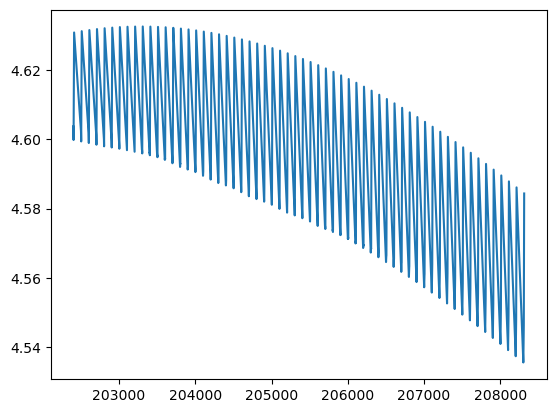

In [280]:
# plot the predictions
predictions = np.array(predictions).reshape(-1)
plt.plot(yearmonth_vec[:], predictions[:], label='Predicted')
